In [2]:
import sys
print(sys.version)

3.7.4 (v3.7.4:e09359112e, Jul  8 2019, 14:54:52) 
[Clang 6.0 (clang-600.0.57)]


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np
import pickle
from os import listdir
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
#tqdm.pandas()
from time import time

In [6]:
#read files

#description: https://www.kaggle.com/gspmoreira/news-portal-user-interactions-by-globocom

articles_metadata = pd.read_csv('data/articles_metadata.csv')
clicks_sample = pd.read_csv('data/clicks_sample.csv')

In [5]:
with open('data/articles_embeddings.pickle', 'rb') as pickle_file:
    embeddings = pickle.load(pickle_file)

In [7]:
print('articles_metadata')
display(articles_metadata.head())
print('clicks_sample')
display(clicks_sample.head())
print('embeddings shape')
print(embeddings.shape)

articles_metadata


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


clicks_sample


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


embeddings shape
(364047, 250)


In [19]:
def get_click_data():
    click_dir = 'data/clicks/clicks/'
    columns = ['user_id','click_article_id',] #'click_environment','click_deviceGroup']
    return pd.concat(
        pd.read_csv(click_dir + click_data)[columns] for click_data in tqdm(listdir('data/clicks/clicks'))
    ).drop_duplicates()

In [20]:
user_clicks = get_click_data()

In [357]:
display(user_clicks.head(),user_clicks.nunique())

,user_id,click_article_id
0,0,157541
1,0,68866
2,1,235840
3,1,96663
4,2,119592


user_id             322897
click_article_id     46033
dtype: int64

# Train/Test Split

In [383]:
def train_test_split(df, size, leftover_size):
    start = time()
    df = df[df.groupby('user_id').user_id.transform(len) >= (size + leftover_size)]
    print(time() - start, 'seconds to filter down dataframe')
    
    start = time()
    df_train = df.groupby('user_id').apply(lambda x: x.sample(8)) #.reset_index(drop=True)
    print(time() - start, 'seconds to sub-sample dataframe')
    
    start = time()
    df_test = df[~df.index.isin(df_train.index)]
    print(time() - start, 'seconds to get df_test')
    
    return df_train, df_test

In [384]:
df_train, df_test = train_test_split(user_clicks,8,2)

95.36949682235718 seconds to filter down dataframe
37.521403074264526 seconds to sub-sample dataframe
959.681871175766 seconds to get df_test


In [387]:
df_sample = df_train[0:1600]

In [412]:
df_train.to_csv('data/df_train.csv')
df_test.to_csv('data/df_test.csv')
df_sample.to_csv('data/df_sample.csv')

In [389]:
print(df_train.shape)
print(df_test.shape)
print(df_sample.shape)

(683208, 2)
(2027773, 2)
(1600, 2)


### Read Back

In [4]:
df_train = pd.read_csv('data/df_train.csv')
df_test = pd.read_csv('data/df_test.csv')

In [12]:
df_sample = pd.read_csv('data/df_sample.csv')

# Model 1: Linear Factorization

In [8]:
class LinearModel:
    def __init__(self, user_data, item_embeddings, size=8, embeddings_size=250, T=1):
        self.user_data = user_data
        self.item_embeddings = item_embeddings
        self.T = T
        self.Vd = LinearModel.d.get_embedding_vectors(
            item_embeddings, user_data, size, embeddings_size=embeddings_size
        )
        self.U = self.initialize_user_vectors(
            size=size,embeddings_size=embeddings_size
        )
        self.n_users = int(self.user_data.shape[0]/size)
        self.reset_errors()
        
    def initialize_user_vectors(self,size,embeddings_size=250):
        return np.mean(LinearModel.d.get_embedding_vectors(
            self.item_embeddings,
            self.user_data,
            size,
            embeddings_size=embeddings_size
        ),axis=1) #[:,np.newaxis]
        
    def reset_errors(self):
        #this is for tracking in steps of GD
        self.errors = []
    
    #############################
    ###### SEEN AND UNSEEN ######
    #############################
    
    class d:
        @staticmethod
        def get_embedding_vectors(V_embeddings, df, size, embeddings_size=250):
            return np.hstack(V_embeddings[df.click_article_id.to_list()]).reshape(-1,size,embeddings_size)
    
    class dbar:
        @staticmethod
        def get_unseen(df, u, size, len_):
            return np.random.choice(
                np.delete(
                    np.arange(len_),
                    df[df.index.get_level_values(0)==u].click_article_id,
                ),
                size=size,
            )
        
        @staticmethod
        def get_all_unseen(df, size, test_size, len_=364047):            
            #semi-vectorized version
            return df.user_id[0::size].map(
                lambda u: LinearModel.dbar.get_unseen(df, u, test_size, len_)
            )
        
        @staticmethod
        def get_embedding_vectors(V_embeddings, df, n_users, size, test_size, embeddings_size=250, len_=36047):
            
            return np.hstack(
                V_embeddings[LinearModel.dbar.get_all_unseen(df,size,test_size,len_=len_).tolist()]
            ).reshape(
                n_users,
                -1,
                embeddings_size
            )
        
        
        
    
    ########################
    ##### GD UTILITIES #####
    ########################
    
    class gradient: 
        @staticmethod
        def J(U,Vd,Vdbar, repeat=1, size=8, embedding_size=250,hinge_param=1):
            '''
            Cost for linear model.
            Size refers to size of axis 1 for max function (hinge loss)
            '''
            
            cost = hinge_param + np.tensordot(U,Vdbar,axes=(1,2))[0] - np.tensordot(U,Vd,axes=(1,2))[0]
            
            
            return np.sum(
                np.max(
                    [np.zeros((U.shape[0]*size)), cost.ravel()], axis = 0
                )
            )
        
        @staticmethod
        def dJ(U,Vd,Vdbar,size=8,embedding_size=250,hinge_param=1):
            #conditional derivitive
            
            
            return np.sum(
                (
                    hinge_param + np.tensordot(U,Vdbar,axes=(1,2))[0]
                    - np.tensordot(U,Vd,axes=(1,2))[0] > 0
                ).repeat(
                    embedding_size
                ).reshape(-1,size,embedding_size) * (Vdbar - Vd),
                axis=1
            )
    
    def gradient_descent_linear(
        self,
        alpha=0.1,
        size=8,
        test_size=128,
        embeddings_size=250,
        test=True,
        hinge_param=1,
        iteration=0,
        max_iterations=500
    ):

        #resample stuff
        Vdbar_small = LinearModel.dbar.get_embedding_vectors(
            self.item_embeddings,
            self.user_data,
            self.n_users,
            size,
            size,
            embeddings_size=embeddings_size,
        )[0:self.U.shape[0]]

        self.U = self.U - alpha * LinearModel.gradient.dJ(
            self.U,
            self.Vd,
            Vdbar_small,
        ) #fix this
        
        
        while True:
            if test == True:
                
                Vdbar_big = LinearModel.dbar.get_embedding_vectors(
                    self.item_embeddings,
                    self.user_data,
                    self.n_users,
                    size,
                    test_size,
                    embeddings_size=embeddings_size,
                )

                J = LinearModel.gradient.J(
                    self.U,
                    self.Vd.repeat(test_size/size,axis=1),
                    Vdbar_big,
                    size=test_size,
                    embedding_size=250,
                    hinge_param=1
                )


                
                self.errors.append(J)
                
            if iteration == max_iterations:
                #stop iterating
                #display errors
                plt.figure(figsize=(12,8))
                plt.xlabel('Iterations')
                sns.lineplot(
                    x = range(len(self.errors)),
                    y = self.errors
                )
                return self.U
            #print(iteration)
            iteration += 1
            return self.gradient_descent_linear(
                alpha=alpha, 
                size=size,
                test_size=test_size,
                embeddings_size=embeddings_size,
                test=test, 
                hinge_param=hinge_param,
                iteration=iteration, 
                max_iterations=max_iterations)

# Model 2: Multiple User Latent Vectors

In [86]:
class NonlinearModel(LinearModel):
    def initialize_user_vectors(self,size,embeddings_size):
        '''
        sets self.U in parent class __init__
        uses clustering methods defined in the Cluster sub-class
        '''
        starting_vectors = LinearModel.d.get_embedding_vectors(
            self.item_embeddings,
            self.user_data,
            size,
            embeddings_size=embeddings_size
        )
        
        return NonlinearModel.Cluster.k_means(starting_vectors,self.T)
        #return NonlinearModel.Cluster.starting_centroids(starting_vectors,self.T)
    
    
    class Cluster():
        @staticmethod
        def starting_centroids(points,T):
            '''
            initialize centroids by randomly picking an item for each user
            '''
            starter_idx = np.random.rand(points.shape[0],T).argsort(axis=-1)[:,0:T,np.newaxis]
            return np.take_along_axis(
                points,
                starter_idx,
                axis=1
            )

        @staticmethod
        def closest_centroid(points, centroids):
            '''
            find the closest centroid to each point using euclidean distance
            it's ok to use euclidean distance for now because clustering just gives a starting point
            the model will be optimized further during gradient descent
            '''
            return np.argmin(
                np.square(
                    np.sum(
                        np.square(points[:,:,np.newaxis] - centroids[:,np.newaxis]),
                        axis=3
                    ),
                ),
                axis=2
            )

        @staticmethod
        def move_centroids(points,closest,k):
            '''
            find new centroid based on cluster center from closest_centroid
            '''
            
            
            weights = np.equal(
                np.arange(k)[np.newaxis,:,np.newaxis],
                closest[:,np.newaxis,:]
            )

            weights = np.repeat(weights[:,:,:,np.newaxis],points.shape[2],axis=3)
            
            
            points = np.repeat(points[:,np.newaxis],k,axis=1)

            return np.average(
                points,
                weights = weights,
                axis=2
            )

        @staticmethod
        def k_means(starting_vectors,k):
            '''
            Recursive function to optimize kmeans using the functions above,
            starting_centroids, closest_centroid, and move_centroid
            '''
            def iterative_kmeans(starting_vectors,old_centroids, new_centroids,k):
                while True:
                    if np.all(new_centroids == old_centroids):
                        return new_centroids
                    else:
                        old_centroids = new_centroids
                        new_centroids = NonlinearModel.Cluster.move_centroids(
                            starting_vectors,
                            NonlinearModel.Cluster.closest_centroid(
                                starting_vectors,
                                old_centroids
                                ),                                           
                            k,
                        )
                        iterative_kmeans(starting_vectors,old_centroids,new_centroids,k)
            starting_centroids = NonlinearModel.Cluster.starting_centroids(starting_vectors,k)
            return iterative_kmeans(
                starting_vectors,
                np.zeros(starting_centroids.shape),
                starting_centroids,
                k
            )
    

    class gradient():
        @staticmethod
        def argmax_indices(U,Vd):
            '''
            get which interest unit per user, per item, is best for each of their relevant items, d
            output of tensor dot should be 100 x 8 x 3
            output of argmax should be 100 x 8
            '''
            return np.argmax(
                np.tensordot(
                    Vd,
                    U,
                    axes=(2,2)
                )[:,:,0],
                axis=2
            )
        
        @staticmethod
        def argmax_indices_modified(U,Vd,Vdbar):
            return np.argmin(
                np.tensordot(Vdbar,U,axes=(2,2))[:,:,0] - np.tensordot(Vd,U,axes=(2,2))[:,:,0] ,
                axis=2)
        
        @staticmethod
        def dJi(Ui,argmax_indices,Vd,Vdbar,T,hinge_param=1):
            '''
            Note that Ui has only the relevant vector (interest unit), while U has all vectors.
            
            
            '''

#             partial_gradient = np.sum(
#                 (
#                     hinge_param + np.tensordot(Ui,Vdbar,axes=(2,2))[0,0]
#                     - np.tensordot(Ui,Vd,axes=(2,2))[0,0] > 0
#                 ).repeat(
#                     250
#                 ).reshape(-1,8,250) * (Vdbar - Vd),
#                 axis=1
#             )
            
            
            #see if it adds up to more than 0, if it does, it counts toward the cost.
            cond = hinge_param + np.tensordot(Ui,Vdbar,axes=(2,2))[0,0] - np.tensordot(Ui,Vd,axes=(2,2))[0,0] > 0


            
            #the gradient is vdbar - vd
            #g = Vdbar - Vd
            g = Vdbar - Vd
            
            #multiply the calculated gradient by the condition (true and false translate to 1 and 0)
            partial_gradient = g * cond[:,:,np.newaxis]
            
            #the next part applies the gradient to only the relevant interest unit
            broadcast_gradient=partial_gradient[:,np.newaxis].repeat(T,axis=1)
            
            #something might be funky with the boolean matrix which could be causing issues
            boolean_matrix = np.equal(argmax_indices[:,np.newaxis],np.arange(T)[np.newaxis,:,np.newaxis])
            
#             print(np.sum(boolean_matrix,axis=1))
            
#             dj = np.sum(np.multiply(broadcast_gradient, boolean_matrix[:,:,:,np.newaxis]), axis=2)
            
#             print('dj before summing')
#             print(np.multiply(broadcast_gradient, boolean_matrix[:,:,:,np.newaxis]).shape)
#             print(np.multiply(broadcast_gradient, boolean_matrix[:,:,:,np.newaxis])[0,:,:,1:10])
#             print('')
            
#             print('dj')
#             print(dj.shape)
#             print(dj[0])
            
            return np.sum(broadcast_gradient * boolean_matrix[:,:,:,np.newaxis], axis=2)
        
        
        @staticmethod
        def J(Ui,Vd,Vdbar,hinge_param=1):
            '''
            description
            '''
            cost = hinge_param + np.tensordot(Ui,Vdbar,axes=(2,2))[0,0] - np.tensordot(Ui,Vd,axes=(2,2))[0,0]
            return np.sum(
                np.max(
                    [np.zeros((cost.shape[0],cost.shape[1])), cost], axis = 1
                )
            )

        
    def get_Vdbar_test(self,test_size=128,embeddings_size=250):
        self.Vdbar_test = LinearModel.dbar.get_embedding_vectors(
                self.item_embeddings,
                self.user_data,
                test_size,
                embeddings_size=embeddings_size,
            )
        
        

    def gradient_descent_nonlinear(
        self,
        alpha=0.01,
        size=8,
        batch_size=16,
        test_size=128,
        embeddings_size=250,
        test=True,
        use_vdbar_for_interest_unit=False,
        hinge_param=1,
        max_iterations=500,
        readj_interval=1,
        gd_algorithm = None
    ):
        
        self.reset_errors()
        
        batch_mult = int(batch_size/size)
        
        if gd_algorithm == 'rprop':
            gd_algorithm = np.sign
        else:
            gd_algorithm = lambda x: x
        
        
        
        
        for iteration in tqdm(range(max_iterations)):
            
            #get vdbar for gradient calculation
            Vdbar = LinearModel.dbar.get_embedding_vectors(
                self.item_embeddings,
                self.user_data,
                self.n_users,
                size,
                size*batch_mult,
                embeddings_size=embeddings_size,
            )
            
            ##readjustment interval
            if iteration % readj_interval == 0:
                if use_vdbar_for_interest_unit == True:
                    argmax_indices = NonlinearModel.gradient.argmax_indices_modified(self.U,self.Vd,Vdbar)
                else:
                    argmax_indices = NonlinearModel.gradient.argmax_indices(self.U,self.Vd)

            #Ui refers to just the relevant user interest vector. n_users x n_items x m
            Ui = np.take_along_axis(
                self.U,
                argmax_indices[:,:,np.newaxis],
                axis=1
            )

            

            ### UPDATE ###
            self.U = self.U - alpha / batch_mult * gd_algorithm(NonlinearModel.gradient.dJi( 
                Ui.repeat(batch_mult,axis=1), ##
                argmax_indices.repeat(batch_mult,axis=1),
                self.Vd.repeat(batch_mult,axis=1), ##
                Vdbar,
                self.T,
                hinge_param=hinge_param))
            ###############

            if test == True:
                #get Vdbar
                Vdbar_test = LinearModel.dbar.get_embedding_vectors(
                    self.item_embeddings,
                    self.user_data,
                    self.n_users,
                    size,
                    test_size,
                    embeddings_size=embeddings_size,
                )


                #add the error at this step to the list of errors so it can be graphed
                #note that this is with a different Vdbar than the one used to calculate gradient
                self.errors.append(
                    NonlinearModel.gradient.J(Ui,self.Vd.repeat(test_size/size,axis=1),Vdbar_test,hinge_param=1) / test_size
                )

            if iteration == max_iterations - 1:
                if test == True:

                    plt.figure(figsize=(12,8))
                    plt.xlabel('Iterations')
                    sns.lineplot(
                        x = range(len(self.errors)),
                        y = self.errors
                    )

                return None
            
            iteration += 1
            
#             return self.gradient_descent_nonlinear(
#                 alpha=alpha,
#                 size=size,
#                 test_size=test_size,
#                 embeddings_size=embeddings_size,
#                 test=test,
#                 hinge_param=hinge_param,
#                 iteration=iteration,
#                 max_iterations=max_iterations
#         )

## Fix nonlinear

In [197]:
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=False,
    alpha=0.01,
    max_iterations=0,
    test_size=128,
    hinge_param = 25,
)

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


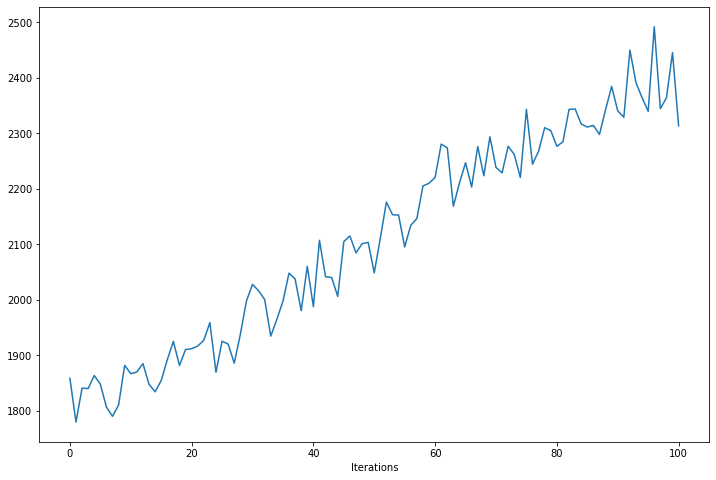

In [234]:
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=1)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.001,
    max_iterations=100,
    test_size=128,
    hinge_param = 25,
)
print(time() - start, 'seconds')

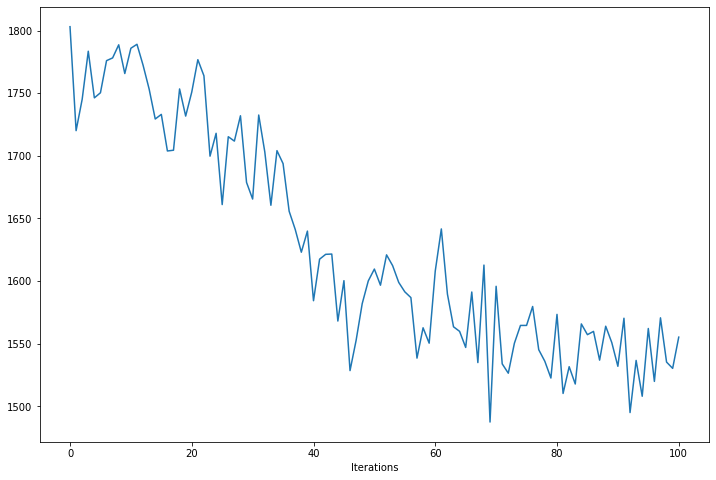

In [201]:
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=1)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.001,
    max_iterations=100,
    test_size=128,
    hinge_param = 1,
)
print(time() - start, 'seconds')

### NONLINEAR TESTING

811.5084829330444 seconds


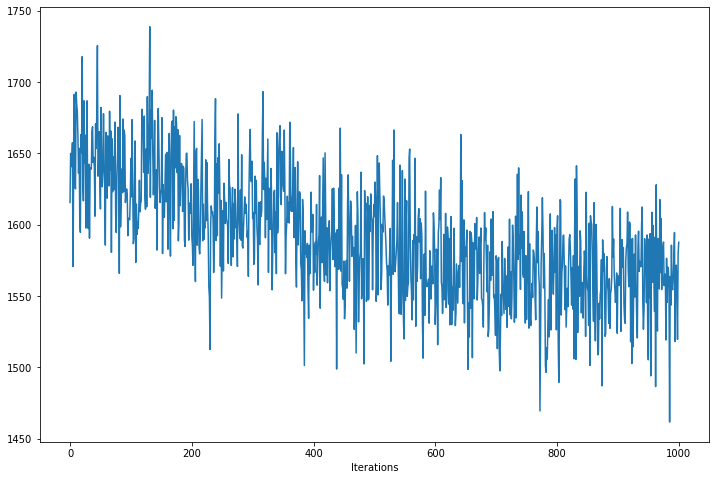

In [242]:
#this is without the regular kmeans shit
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.01,
    max_iterations=1000,
    test_size=128,
    hinge_param = 1,
    readj_interval=200,
)
print(time() - start, 'seconds')

1609.9616975784302 seconds


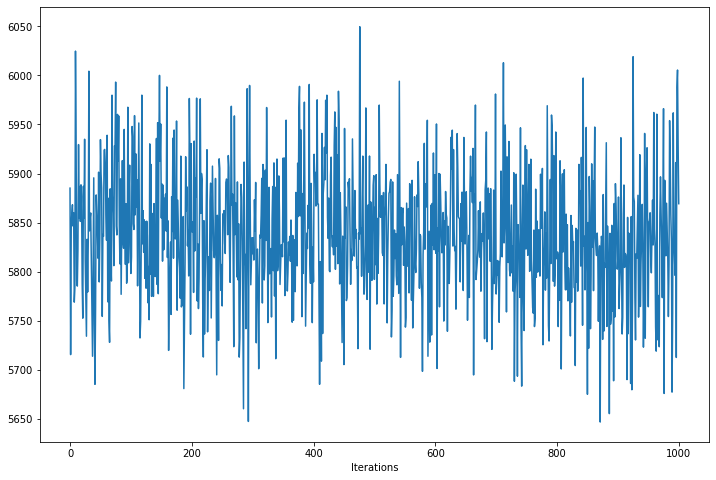

In [17]:
#this is WITH the regular kmeans shit
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.005,
    max_iterations=1000,
    batch_size=32,
    test_size=256,
    hinge_param = 1,
    readj_interval=100,
    gd_algorithm=lambda x: x
)
print(time() - start, 'seconds')

6451.0723378658295 seconds


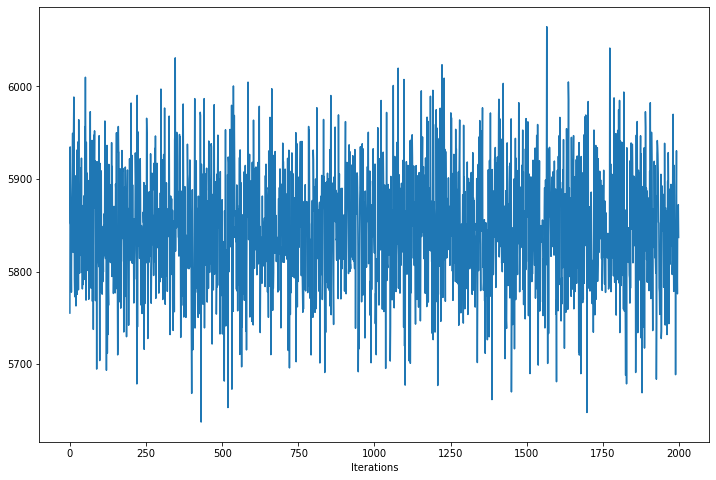

In [23]:
#this is WITH the regular kmeans shit
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.001,
    max_iterations=2000,
    batch_size=64,
    test_size=256,
    hinge_param = -1,
    readj_interval=200,
    gd_algorithm=lambda x: x
)
print(time() - start, 'seconds')

5206.125770807266 seconds


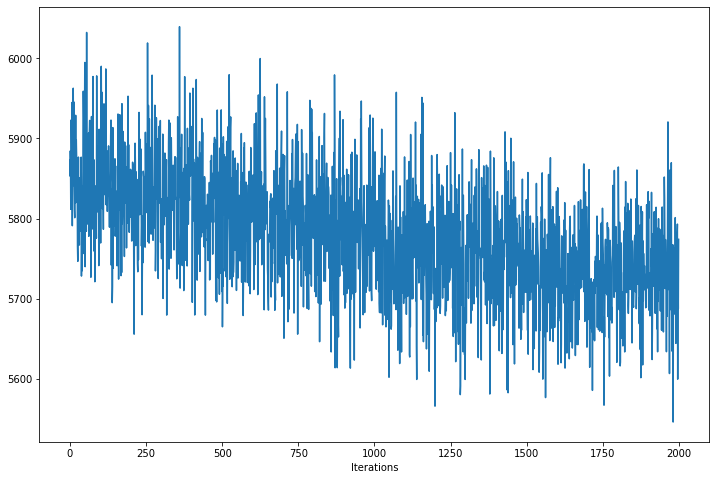

In [25]:
#this is WITH the regular kmeans shit
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.01,
    max_iterations=2000,
    batch_size=64,
    test_size=256,
    hinge_param = 1,
    readj_interval=200,
    gd_algorithm=lambda x: x
)
print(time() - start, 'seconds')

6146.48138999939 seconds


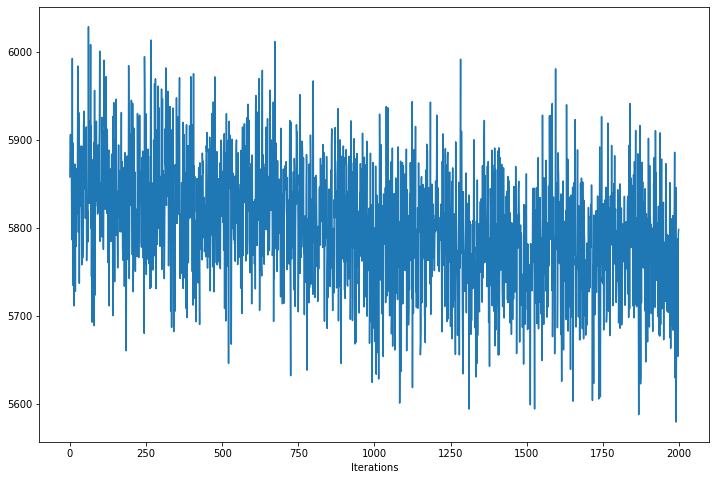

In [30]:
#this is WITH the regular kmeans shit
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.01,
    max_iterations=2000,
    batch_size=64,
    test_size=256,
    hinge_param = 1,
    readj_interval=50,
    gd_algorithm=lambda x: x
)
print(time() - start, 'seconds')

# CONVERGE FASTER!!!

26.03788423538208 seconds


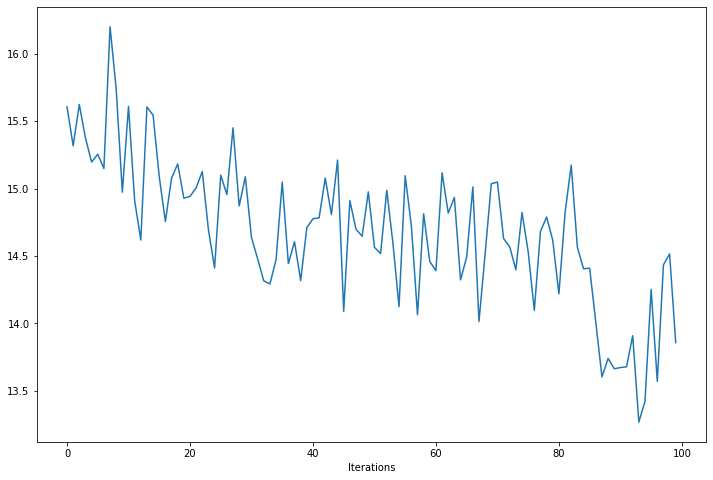

In [93]:
nm = NonlinearModel(df_sample.iloc[0:800],embeddings,size=8, embeddings_size=250, T=2)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.1,
    max_iterations=100,
    test_size=128,
    hinge_param = 5,
    readj_interval=10,
    gd_algorithm=None
)
print(time() - start, 'seconds')

54.14532494544983 seconds


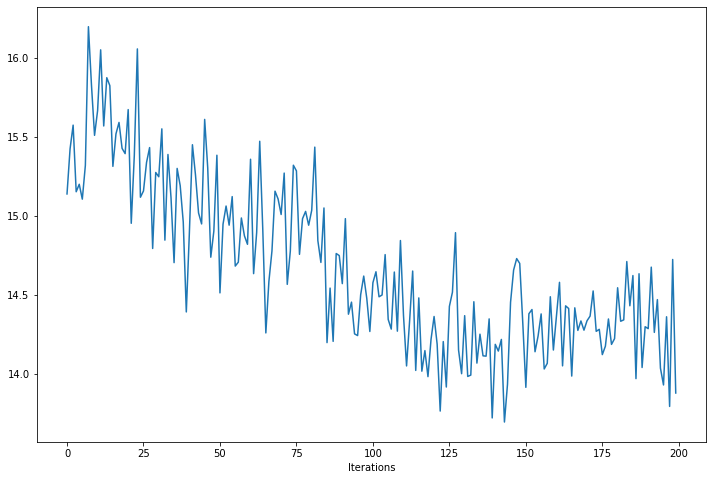

In [94]:
nm = NonlinearModel(df_sample.iloc[0:800],embeddings,size=8, embeddings_size=250, T=2)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.1,
    max_iterations=200,
    test_size=128,
    hinge_param = 5,
    readj_interval=10,
    gd_algorithm=None
)
print(time() - start, 'seconds')

61.342652797698975 seconds


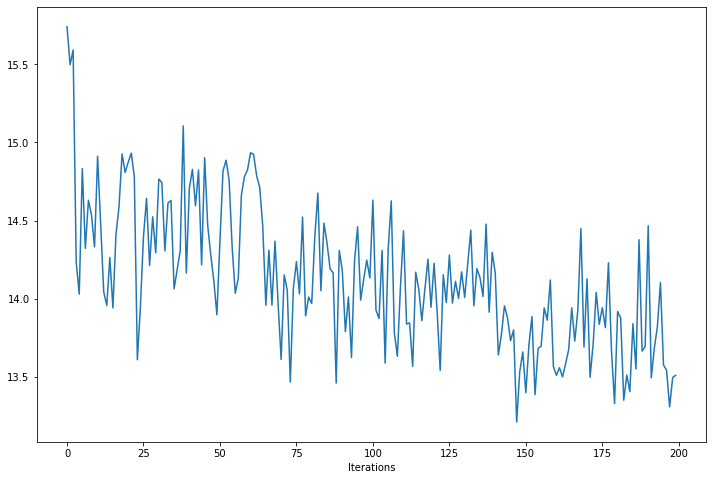

In [95]:
nm = NonlinearModel(df_sample.iloc[0:800],embeddings,size=8, embeddings_size=250, T=2)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.1,
    max_iterations=200,
    test_size=128,
    hinge_param = 5,
    readj_interval=1,
    gd_algorithm=None
)
print(time() - start, 'seconds')

249.0185260772705 seconds


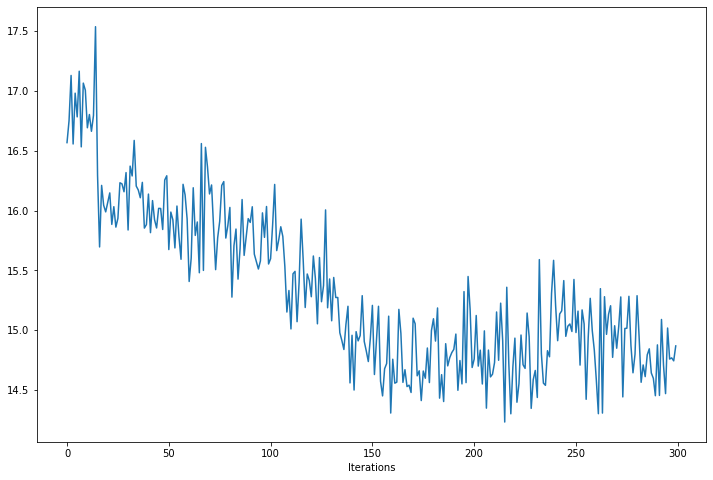

In [96]:
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=2)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.1,
    max_iterations=300,
    test_size=128,
    hinge_param = 5,
    readj_interval=1,
    gd_algorithm=None
)
print(time() - start, 'seconds')

36.45750975608826 seconds


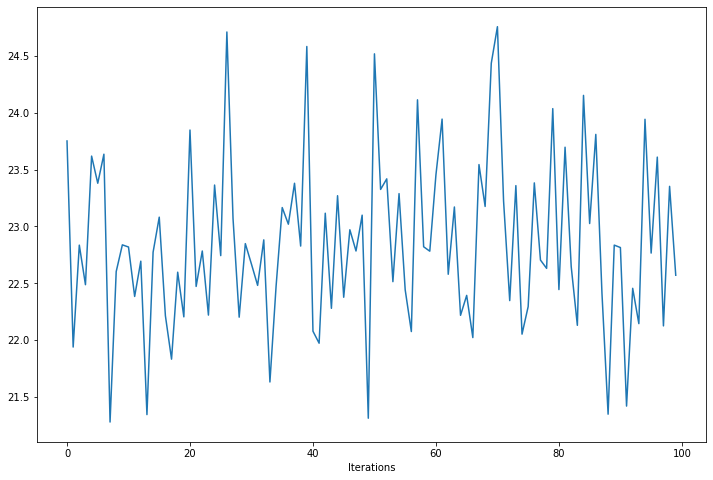

In [46]:
#this is WITH the regular kmeans shit
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.01,
    max_iterations=100,
    batch_size=8,
    test_size=32,
    hinge_param = 1,
    use_vdbar_for_interest_unit = False,
    readj_interval=1,
    gd_algorithm='rprop'
)
print(time() - start, 'seconds')

38.57018494606018 seconds


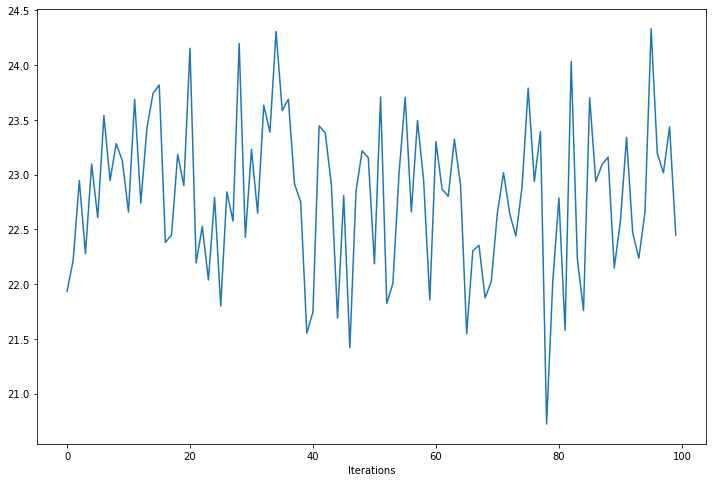

In [48]:
#this is WITH the regular kmeans shit
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.001,
    max_iterations=100,
    batch_size=8,
    test_size=32,
    hinge_param = 1,
    use_vdbar_for_interest_unit = False,
    readj_interval=10,
    gd_algorithm='rprop'
)
print(time() - start, 'seconds')

6.609045028686523 seconds


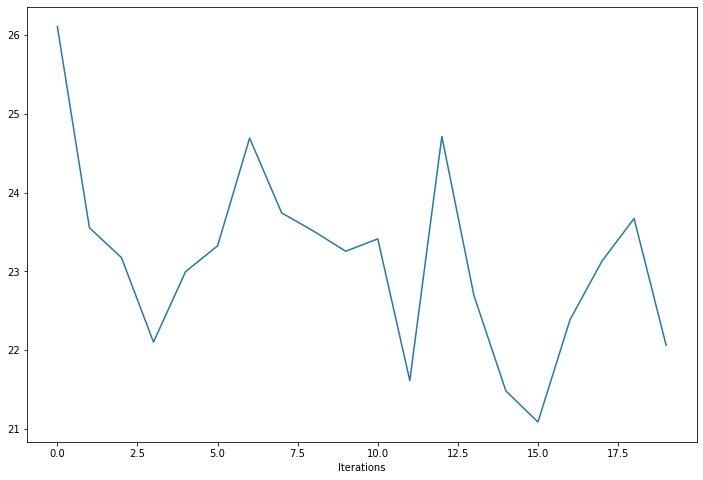

In [69]:
#this is WITH the regular kmeans shit
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.01,
    max_iterations=20,
    batch_size=8,
    test_size=16,
    hinge_param = 1,
    use_vdbar_for_interest_unit = True,
    readj_interval=5,
   #gd_algorithm='rprop'
)
print(time() - start, 'seconds')

18.514623880386353 seconds


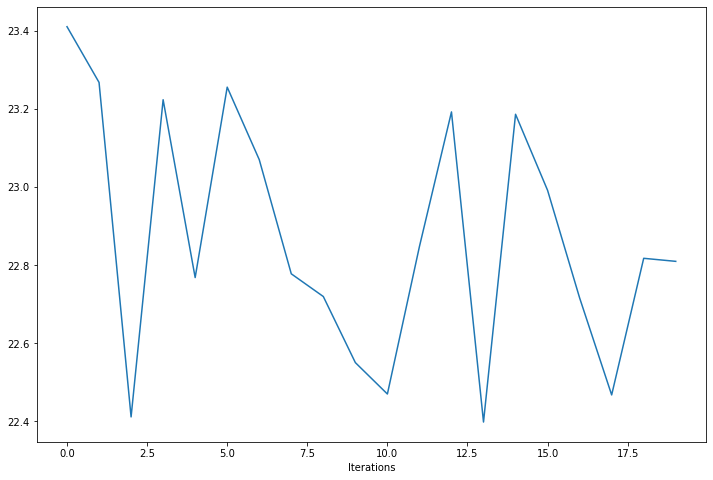

In [73]:
#this is WITH the regular kmeans shit
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.01,
    max_iterations=20,
    batch_size=8,
    test_size=192,
    hinge_param = 1,
    use_vdbar_for_interest_unit = True,
    readj_interval=5,
    gd_algorithm='rprop'
)
print(time() - start, 'seconds')

interval is now 15
interval is now 29
interval is now 57
37.00756621360779 seconds


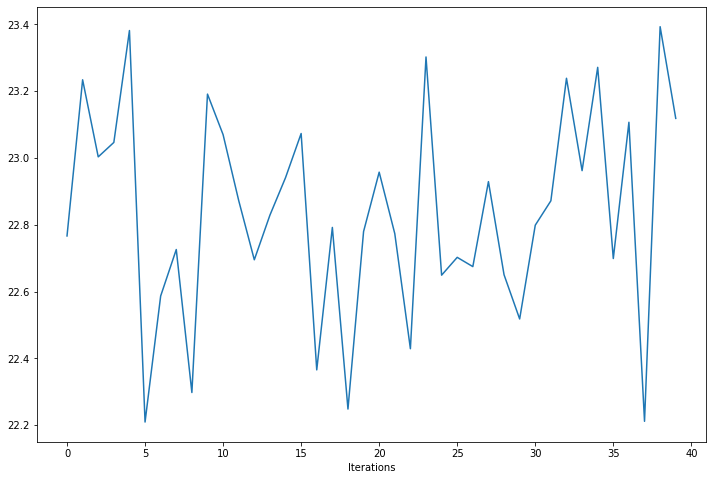

In [85]:
#this is WITH the regular kmeans shit
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.001,
    max_iterations=40,
    batch_size=8,
    test_size=192,
    hinge_param = -5,
    use_vdbar_for_interest_unit = False,
    readj_interval=8,
    gd_algorithm=None
)
print(time() - start, 'seconds')

In [ ]:
#this is WITH the regular kmeans shit
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.01,
    max_iterations=100,
    batch_size=8,
    test_size=32,
    hinge_param = 1,
    use_vdbar_for_interest_unit = True,
    readj_interval=1,
    gd_algorithm='rprop'
)
print(time() - start, 'seconds')

4996.363065004349 seconds


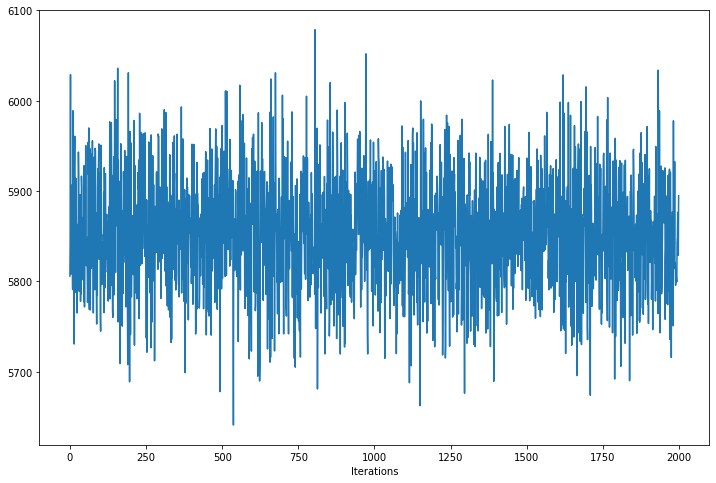

In [26]:
#this is WITH the regular kmeans shit
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.01,
    max_iterations=2000,
    batch_size=64,
    test_size=256,
    hinge_param = -25,
    readj_interval=200,
    gd_algorithm=lambda x: x
)
print(time() - start, 'seconds')

4997.694910287857 seconds


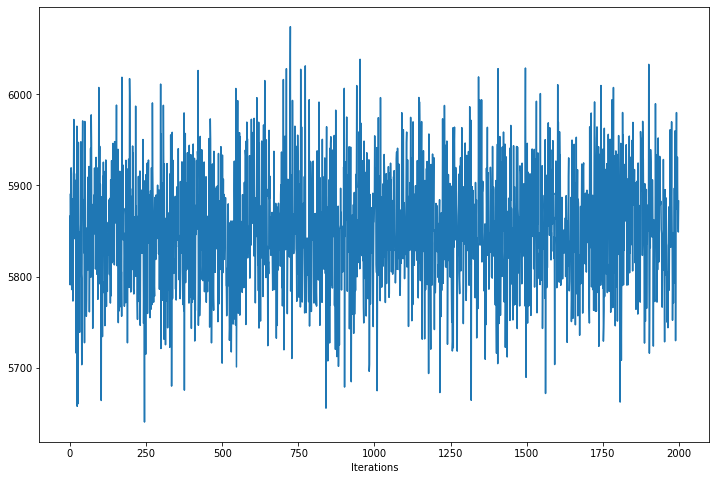

In [27]:
#this is WITH the regular kmeans shit
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.01,
    max_iterations=2000,
    batch_size=64,
    test_size=256,
    hinge_param = -50,
    readj_interval=200,
    gd_algorithm=lambda x: x
)
print(time() - start, 'seconds')

75.29519701004028 seconds


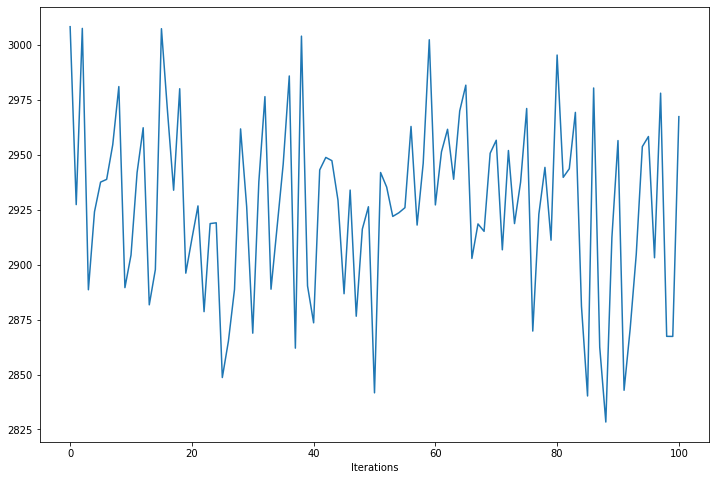

In [233]:
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.001,
    max_iterations=100,
    test_size=128,
    hinge_param = 1,
    readj_interval=100,
)
print(time() - start, 'seconds')

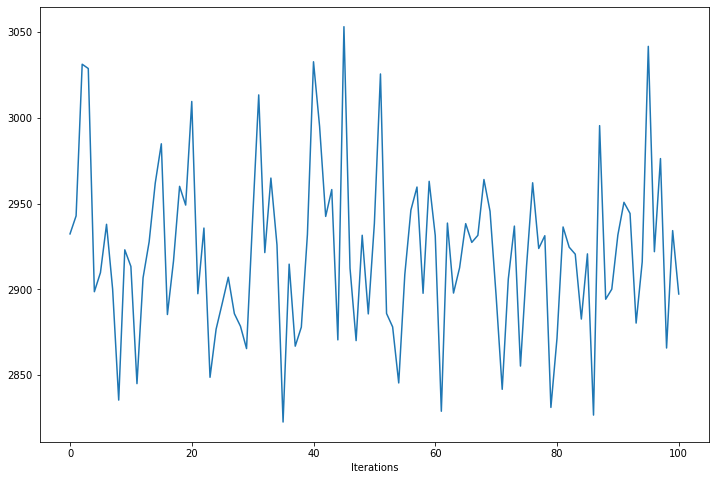

In [208]:
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.001,
    max_iterations=100,
    test_size=128,
    hinge_param = -np.inf,
)

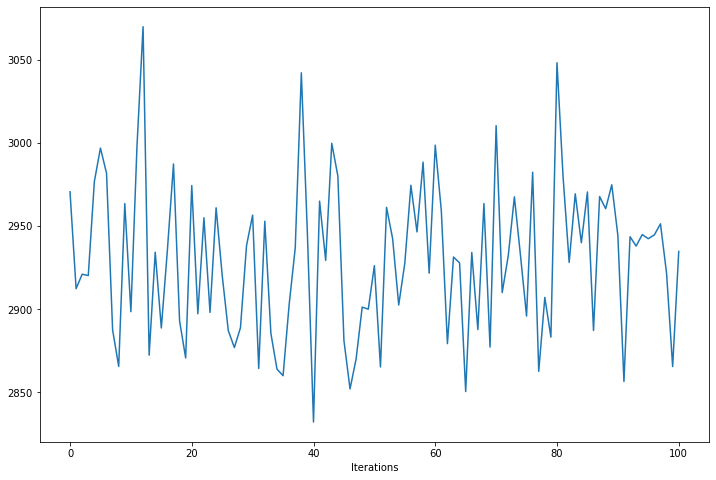

In [209]:
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.001,
    max_iterations=100,
    test_size=128,
    hinge_param = -10,
)

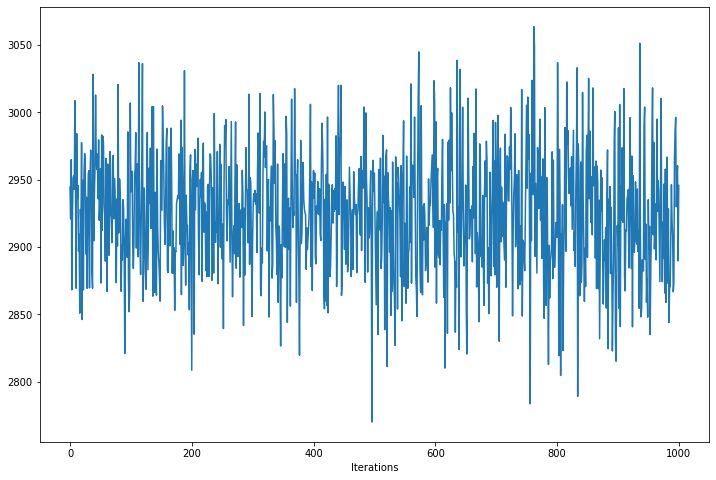

In [216]:
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.01,
    max_iterations=1000,
    test_size=128,
    hinge_param = -10,
)

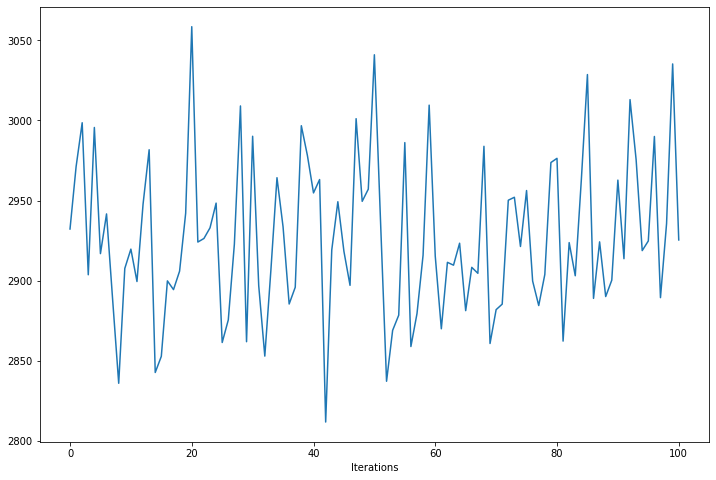

In [211]:
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.1,
    max_iterations=100,
    test_size=128,
    hinge_param = -10,
)

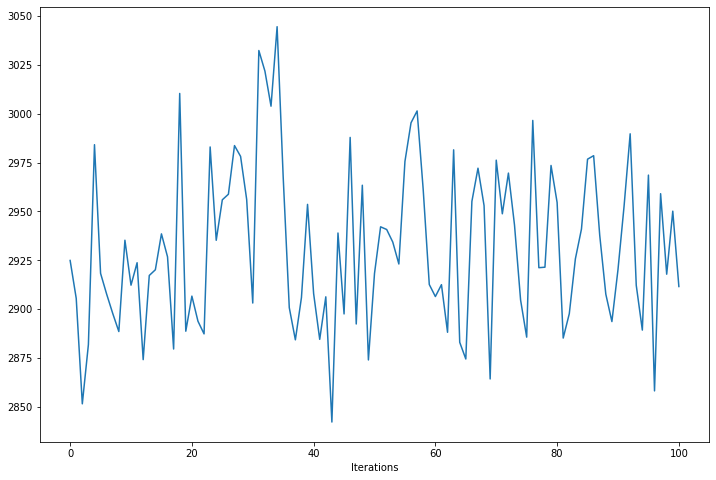

In [217]:
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.1,
    max_iterations=100,
    test_size=128,
    hinge_param = -np.inf,
)

In [218]:
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.0025, max_iterations=1200,
    test_size=128,
    hinge_param = -15,
)

SyntaxError: invalid syntax (<ipython-input-218-0a1ec7d6cf94>, line 6)

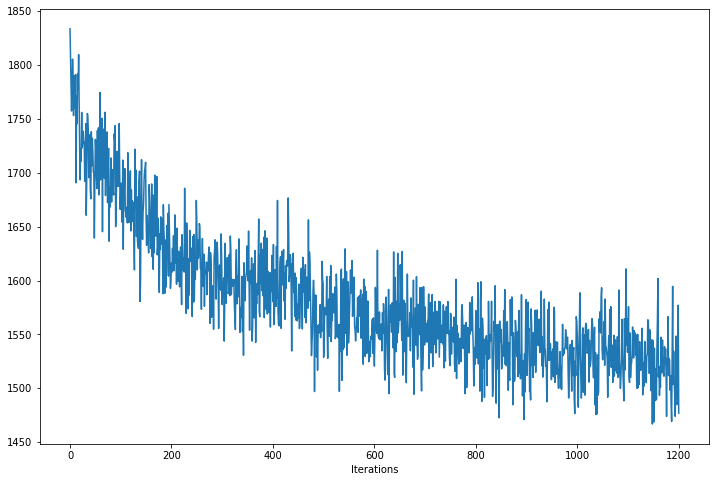

In [203]:
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=1)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.0025, max_iterations=1200
    test_size=128,
    hinge_param = 1,
)

In [ ]:
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=1)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.0025, max_iterations=1200
    test_size=128,
    hinge_param = 1,
)
print(time() - start, 'seconds')

# Test Models
### Linear Model

In [ ]:
#the one
lm = LinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=1)
print(lm.U[0:3,0:10])
start = time()
lm.gradient_descent_linear(test=True,alpha=0.0025, max_iterations=1200, test_size=64, hinge_param = 1)
print(time() - start, 'seconds')

In [76]:
#the one
lm = LinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=1)
print(lm.U[0:3,0:10])
start = time()
lm.gradient_descent_linear(test=True,alpha=0.0001, max_iterations=1000, test_size=128, hinge_param = 1)
print(time() - start, 'seconds')

[[-0.28541464 -0.96553236 -0.38346538 -0.28515273 -0.26262957 -0.08807504
  -0.22524355  0.07767095  0.10888471 -0.06904735]
 [-0.6923317  -0.96866435 -0.10574491 -0.40240848 -0.05122528 -0.4845463
  -0.6268408  -0.27837464  0.08891039 -0.29375246]
 [-0.2935815  -0.96710324  0.08459759 -0.34876168 -0.30551022 -0.13571543
  -0.12978128 -0.09540445  0.19894657  0.09829965]]


KeyboardInterrupt: 

### Nonlinear Model

[[[-0.43227705 -0.968928   -0.37450257 -0.39280468 -0.4067312
   -0.572993    0.05936673 -0.04113737  0.48127902 -0.4064353 ]
  [-0.03008582 -0.9633234  -0.4172627  -0.28452262 -0.1613579
    0.3590363  -0.44542468  0.3377726  -0.05251075  0.21263017]
  [-0.46395153 -0.95857674 -0.31792468  0.14356467  0.00996184
    0.5102628  -0.7031411  -0.22740082 -0.896506    0.43547192]]

 [[-0.4751659  -0.9735536   0.5987766  -0.76024616 -0.7657359
   -0.2390801   0.6352061  -0.45419365  0.4957461   0.4945859 ]
  [-0.7370808  -0.9683482  -0.16365026 -0.34577748  0.11377787
   -0.4865161  -0.83276415 -0.27290443 -0.04409396 -0.48182586]
  [-0.6410029  -0.96567214 -0.46283427 -0.38435704 -0.3267334
   -0.7181939  -0.6533475  -0.13537717  0.48010078  0.04634963]]

 [[-0.05437755 -0.9567325   0.07383814 -0.15060993  0.20312737
    0.40595245 -0.5529446   0.10490312  0.00827456  0.21330519]
  [-0.3251211  -0.96754885  0.48227483 -0.48464328 -0.8998877
   -0.35965246  0.2693282  -0.22352673  0.7554367

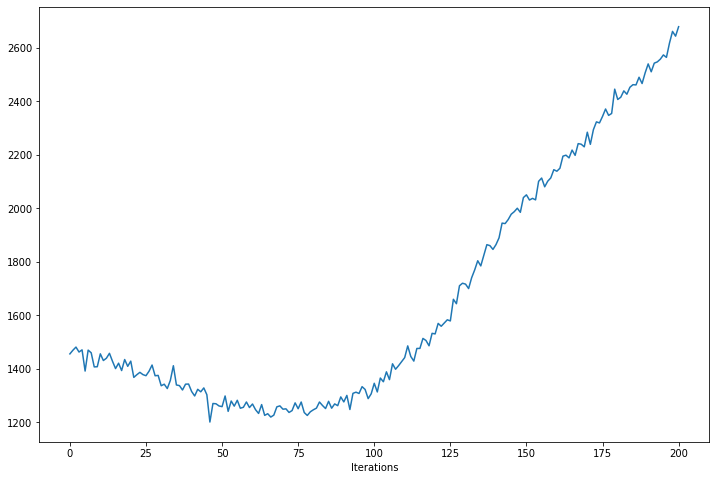

In [16]:
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
print(nm.U[0:3,:,0:10])

start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=-0.0025,
    gd_repeat=1,
    max_iterations=200,
    test_size=64,
    hinge_param = 25
)
print(time() - start, 'seconds')

[[[-0.03008582 -0.9633234  -0.4172627  -0.28452262 -0.1613579
    0.3590363  -0.44542468  0.3377726  -0.05251075  0.21263017]
  [-0.43227705 -0.968928   -0.37450257 -0.39280468 -0.4067312
   -0.572993    0.05936673 -0.04113737  0.48127902 -0.4064353 ]
  [-0.46395153 -0.95857674 -0.31792468  0.14356467  0.00996184
    0.5102628  -0.7031411  -0.22740082 -0.896506    0.43547192]]

 [[-0.7370808  -0.9683482  -0.16365026 -0.34577748  0.11377787
   -0.4865161  -0.83276415 -0.27290443 -0.04409396 -0.48182586]
  [-0.4751659  -0.9735536   0.5987766  -0.76024616 -0.7657359
   -0.2390801   0.6352061  -0.45419365  0.4957461   0.4945859 ]
  [-0.6410029  -0.96567214 -0.46283427 -0.38435704 -0.3267334
   -0.7181939  -0.6533475  -0.13537717  0.48010078  0.04634963]]

 [[-0.3251211  -0.96754885  0.48227483 -0.48464328 -0.8998877
   -0.35965246  0.2693282  -0.22352673  0.7554367   0.31585515]
  [-0.05437755 -0.9567325   0.07383814 -0.15060993  0.20312737
    0.40595245 -0.5529446   0.10490312  0.0082745

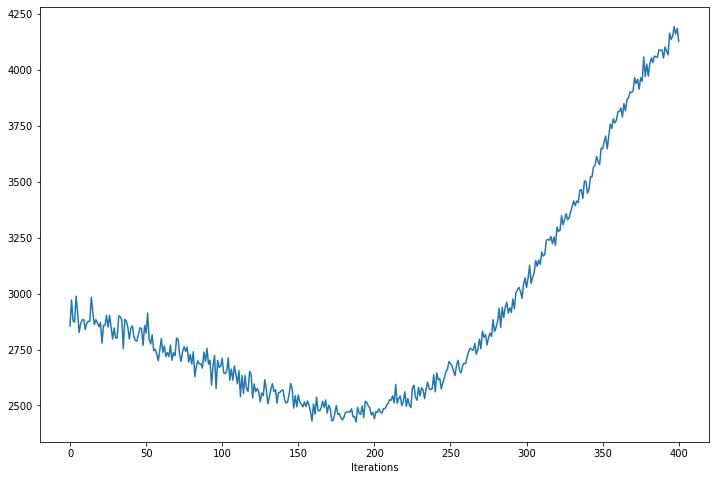

In [10]:
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
print(nm.U[0:3,:,0:10])

start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=-0.001,
    gd_repeat=1,
    max_iterations=400,
    test_size=128,
    hinge_param = 25
)
print(time() - start, 'seconds')

# Cross-Validation